In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [31]:
# Load CSV files
file_paths = glob.glob("csvs/*.csv")
dataframes = {}

# Read and clean files
for file in file_paths:
    df = pd.read_csv(file, dtype=str)
    df.columns = df.columns.str.strip()
    file_name = file.split("/")[-1]
    dataframes[file_name] = df
    print(f"\n{file_name}")
    print(df.head())


Amazon Sale Report.csv
  index             Order ID      Date                        Status  \
0     0  405-8078784-5731545  04-30-22                     Cancelled   
1     1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2     2  404-0687676-7273146  04-30-22                       Shipped   
3     3  403-9615377-8133951  04-30-22                     Cancelled   
4     4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel ship-service-level    Style              SKU  \
0   Merchant     Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant     Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon     Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant     Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon     Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0            Set  ...   

In [32]:
# Standardize SKU column names
sales_files = ["Amazon Sale Report.csv", "Sale Report.csv", "International sale Report.csv", "International sale Report-1.csv"]
for file in sales_files:
    if file in dataframes:
        df = dataframes[file]
        df.rename(columns={"SKU Code": "SKU", "Sku": "SKU"}, inplace=True)

In [33]:
# Merge sales data
merged_sales_df = pd.concat([dataframes[file] for file in sales_files if file in dataframes], ignore_index=True)
merged_sales_df.to_csv("merged_sales_data.csv", index=False)
print("\nMerged sales data saved as 'merged_sales_data.csv'!")


Merged sales data saved as 'merged_sales_data.csv'!


In [34]:
# Load merged data
df = pd.read_csv("merged_sales_data.csv")
df.drop_duplicates(inplace=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
if "Amount" in df.columns:
    df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce").fillna(0)

total_sales = df["Amount"].sum()
print(f"Total Sales Revenue: ${total_sales:,.2f}")

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_35137/3013169259.py:2: DtypeWarning: Columns (1,2,3,4,5,6,9,10,11,12,14,16,17,19,20,21,22,23,24,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_sales_data.csv")


Total Sales Revenue: $78,592,678.30


/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_35137/3013169259.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [35]:
# Grouping small categories into 'Other'
def group_small_categories(series, threshold=0.02):
    total = series.sum()
    small_values = series[series / total < threshold]
    series = series.drop(small_values.index)
    series["Other"] = small_values.sum()
    return series

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_35137/1806115399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette="viridis")


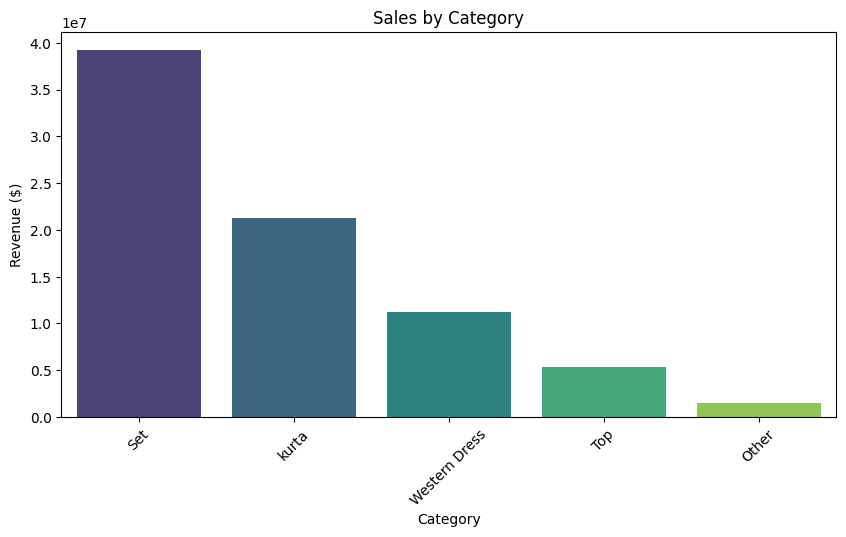

In [36]:
# Sales by Category
if "Category" in df.columns:
    category_sales = df.groupby("Category")["Amount"].sum().sort_values(ascending=False)
    category_sales = group_small_categories(category_sales)
    plt.figure(figsize=(10,5))
    sns.barplot(x=category_sales.index, y=category_sales.values, palette="viridis")
    plt.title("Sales by Category")
    plt.xticks(rotation=45)
    plt.ylabel("Revenue ($)")
    plt.show()

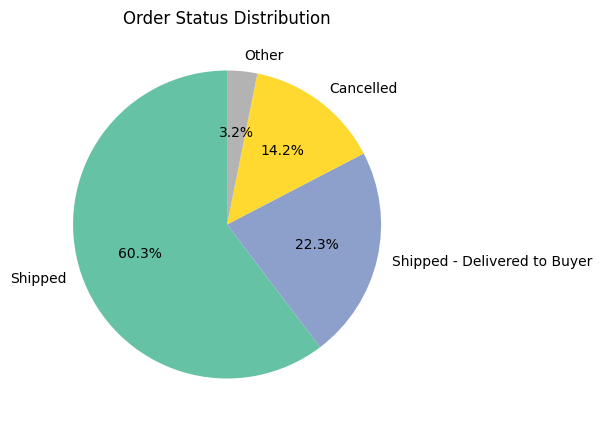

In [39]:
# Order Status Breakdown
if "Status" in df.columns:
    status_counts = df["Status"].value_counts()
    status_counts = group_small_categories(status_counts)
    plt.figure(figsize=(8,5))
    status_counts.plot(kind="pie", autopct="%1.1f%%", cmap="Set2", startangle=90)
    plt.title("Order Status Distribution")
    plt.ylabel("")
    plt.show()

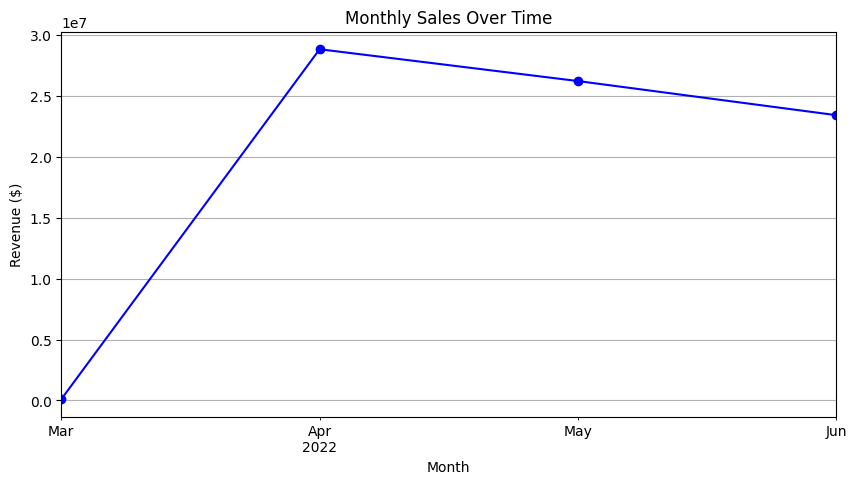

In [40]:
# Sales Over Time
if "Date" in df.columns:
    df["Month"] = df["Date"].dt.to_period("M")
    monthly_sales = df.groupby("Month")["Amount"].sum()
    plt.figure(figsize=(10,5))
    monthly_sales.plot(kind='line', marker='o', color='blue')
    plt.title("Monthly Sales Over Time")
    plt.xlabel("Month")
    plt.ylabel("Revenue ($)")
    plt.grid(True)
    plt.show()